<a href="https://colab.research.google.com/github/ezrafield/ibm-certificate-final/blob/main/find_matrix_rotate_by_SIFT_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy.lib.shape_base import dsplit
from matplotlib.cbook import violin_stats
from numpy.core.arrayprint import format_float_scientific
import numpy as np
import cv2
import matplotlib.pyplot as plt

class RotateMatrix2D:
    def __init__(self, ImageInput1, ImageInput2 = False, degree = 0):
        # image, width, height, MatrixOutput, view
        SIZE = ImageInput1.shape
        self.W, self.H = SIZE[0], SIZE[1]
        self.SIZE = SIZE[:2]
        self.degree = degree
        self.img1 = ImageInput1
        self.img2 = ImageInput2

    #rotate
    def rotateImage(self, degree = 0, viewMatrixRotate = False):
    # quay hình img1 (ảnh gốc)
    # Input: 
    #  - degree : góc quay (theo chiều kim đồng hồ)
    #  - viewMatrixRotate : hiển thị matrix biểu diễn quay không (để so sánh kết quả model)
    # Output: img2 : ảnh sau quay (dạng opencv numpy array)
        if degree == 0:
          degree = self.degree
        height, width = self.SIZE[:2]
        center = (width / 2, height / 2)
        MatrixRotate = cv2.getRotationMatrix2D(center=center, angle= degree, scale=1)
        img2 = cv2.warpAffine(self.img1, MatrixRotate, self.SIZE)
        img2 = cv2.resize(img2, self.SIZE, interpolation=cv2.INTER_AREA)
        if viewMatrixRotate == True:
          print(MatrixRotate)
        return img2

    #SIFT
    def sift(self, img1, img2, view = True):
      # SIFT agorithm cho 2 ảnh
      # Input:
      # - img1, img2 : 2 ảnh cần xét (dạng opencv numpy array)
      # - show : hiện thị biểu diễn 5 match đầu của kết quả SIFT để dễ hình dung
      # Output: 
      # - matches : tập mã hóa match 2 ảnh
      # - keypoints_1, keypoints_2 : tập các đầu mút của tập match ở ảnh 1, ảnh 2
        sift = cv2.SIFT_create()
        keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
        keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)

        # feature matching
        bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

        matches = bf.match(descriptors_1, descriptors_2)
        matches = sorted(matches, key=lambda x: x.distance)

        img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:10], img2, flags=2)
        if view == True:
            plt.imshow(img3)
            plt.show()

        return matches, keypoints_1, keypoints_2, img3

    #keypoint coordinate
    def siftKeypointCoord(self, siftResult, numberCheckExample = 0):
      # tìm tọa độ các điểm được match (giải mã matches)
      # Input:
      # - siftResult: kết quả SIFT (đúng form theo method sift trên)
      # - numberCheckExample: hiện 1 vài phần tử đầu tiên để check
      # Output:
      # - list_kp1, list_kp2: tọa độ các điểm đầu mút match tương ứng
        # Initialize lists
        list_kp1 = []
        list_kp2 = []
        matches, keypoints_1, keypoints_2 = siftResult[0], siftResult[1], siftResult[2]
        # For each match...
        for mat in matches:

            # Get the matching keypoints for each of the images
            img1_idx = mat.queryIdx
            img2_idx = mat.trainIdx

            # x - columns
            # y - rows
            # Get the coordinates
            (x1, y1) = keypoints_1[img1_idx].pt
            (x2, y2) = keypoints_2[img2_idx].pt

            # Append to each list

            if (x1, y1) in list_kp1:
                continue
            list_kp1.append((x1, y1))
            list_kp2.append((x2, y2))

        if numberCheckExample > 0:
            list_sorted_matches_pt = [[list_kp1[i], list_kp2[i]] for i in range(len(list_kp1))]
            print(len(list_sorted_matches_pt))
            print(list_kp1[:numberCheckExample])
            print(list_kp2[:numberCheckExample])

        return list_kp1, list_kp2

    # find matrix rotate (matrix homographic)
    def findMatrixRotateSIFT(self, image1, image2, view = True):
      # tìm matrix quay của 2 ảnh
      # Input:
      # - image1, image2: 2 ảnh cần xét
      # - view: hiển thị ảnh kết quả của algorithm
      # Output:
      # - matrix: matrix quay nhận dạng từ algorithm 
        img2v = image2.copy()
        siftResult = self.sift(img1 = image1, img2 = image2, view = False)
        list_kp1, list_kp2 = self.siftKeypointCoord(siftResult = siftResult, numberCheckExample= 0)

        pts1 = np.float32(list_kp1[:4])
        pts2 = np.float32(list_kp2[:4])

        matrix = cv2.getPerspectiveTransform(pts2, pts1)
        imgOutput = cv2.warpPerspective(img2v, matrix, (self.W, self.H), flags=cv2.INTER_LINEAR)
        if view == True:
            plt.imshow(imgOutput)
            plt.show()
        elif view == False:
            print(matrix)
        
        return matrix, imgOutput

    # Harris Corner Detector
    def Harriscorner(self, image1, view = True):
        img1 = image1.copy()
        gray = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
        gray = np.float32(gray)
        dst = cv2.cornerHarris(gray,2,3,0.04)
        """ cornerHarris	(	
          InputArray 	src,
          int 	ksize,
          int 	blockSize,
          float 	k [, dst[, borderType]
          )	
        """ 

        dst = cv2.dilate(dst,None) # làm loan màu, tác dụng như gauss
        # Threshold
        if view == True:
            img2 = img1.copy()
            img2[dst>0.01*dst.max()]=[0,0,255]

            from google.colab.patches import cv2_imshow
            cv2_imshow(img2)

        tableinit = np.zeros(img1.shape[:2])
        tableinit[dst > 0.01*dst.max()] = 1
        ind = np.argwhere(tableinit == 1)

        # return dst[dst>0.01*dst.max()], img2, dst, 0.01*dst.max()
        return ind

    def findMatrixRotate(self, image, list_kp1, list_kp2, view = True):
      # tìm matrix quay của 2 list keypoint
      # Input:
      # - image: ảnh cần xét
      # - list_kp1, list_kp2: list keypoint 2 ảnh
      # - view: hiển thị ảnh kết quả của algorithm
      # Output:
      # - matrix: matrix quay nhận dạng từ algorithm 
        img2v = image.copy()

        pts1 = np.float32(list_kp1[:4])
        pts2 = np.float32(list_kp2[:4])

        matrix = cv2.getPerspectiveTransform(pts2, pts1)
        imgOutput = cv2.warpPerspective(img2v, matrix, (self.W, self.H), flags=cv2.INTER_LINEAR)
        if view == True:
            plt.imshow(imgOutput)
            plt.show()
        elif view == False:
            print(matrix)
        
        return matrix, imgOutput

## Test

In [ ]:
import urllib
SIZE = (500, 500)

# img1 = cv2.imread('/content/testimg.jpg')
req = urllib.request.urlopen('https://blogger.googleusercontent.com/img/a/AVvXsEhnIBHGDVBtKNb7F23-n-0e7-o-7-CwiLargbjA_dNaBjz3MPoXlPDb6z1fXRPqrezmex89nlapP3ja_udOk4e6_12Y4ya2-YY9g2pV2IvREOoFDhQGnOTvf_UfoKJKbJ7ibSwmf5qiWrlWNjLAb6qhMMf6r0LfUskDJHWPbJwKxg6h2bJCS1WVbI_JCA')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img1 = cv2.imdecode(arr, -1)


In [ ]:
# def __init__(self, ImageInput1, ImageInput2 = False, degree = 0):
classtest = RotateMatrix2D(img1, degree = 30)

In [ ]:
# def rotateImage(self, degree = 0, viewMatrixRotate = False)
# return img2
img2 = classtest.rotateImage(viewMatrixRotate = True)

[[   0.8660254     0.5        -142.90440865]
 [  -0.5           0.8660254   215.67348628]]


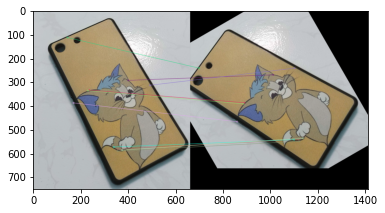

1151


In [ ]:
#SIFT
# def sift(self, img1, img2, show = True)
# return matches, keypoints_1, keypoints_2
siftresult = classtest.sift(img1, img2)
print(len(siftresult[1]))

In [ ]:
# def siftKeypointCoord(self, siftResult, numberCheckExample = 0)
# return list_kp1, list_kp2
list_kp1, list_kp2 = classtest.siftKeypointCoord(siftresult, numberCheckExample = 4)

588
[(170.02291870117188, 386.2171936035156), (355.8668518066406, 580.6013793945312), (400.44873046875, 291.46368408203125), (236.55625915527344, 332.4433898925781)]
[(197.243896484375, 465.2767333984375), (455.4727478027344, 540.6243286132812), (349.4105529785156, 267.97064208984375), (227.98056030273438, 385.4858703613281)]


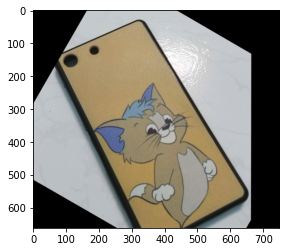

In [ ]:
# def findMatrixRotateSIFT(self, image1, image2, view = True)
# return matrix
matrixlast = classtest.findMatrixRotateSIFT(img1, img2)

In [ ]:
matrixlast

array([[ 8.70016661e-01, -5.00706016e-01,  2.31782730e+02],
       [ 5.04844103e-01,  8.69918253e-01, -1.17207895e+02],
       [ 6.48128861e-06,  2.28892268e-06,  1.00000000e+00]])

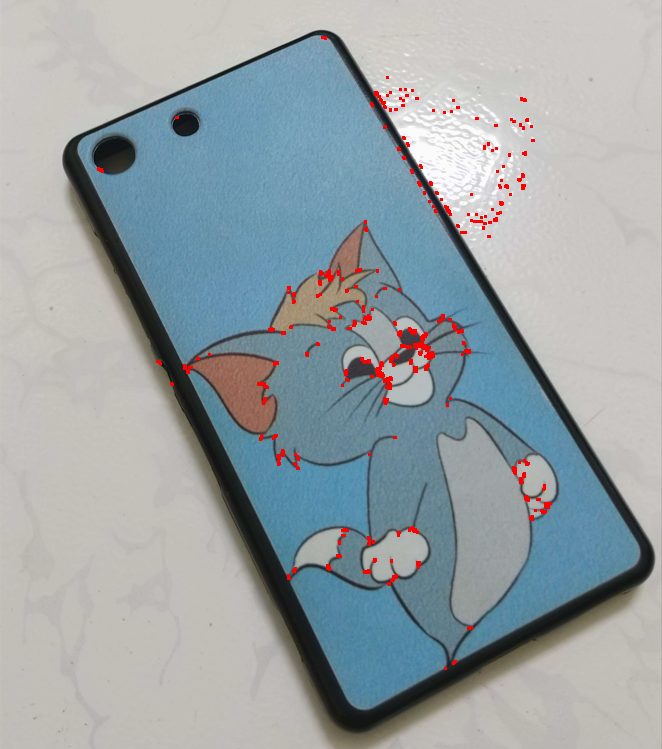

In [ ]:
# def Harriscorner(self, image1, view = True)
# return ind
## harrisresult, img2harris, dst, threshold = classtest.Harriscorner(img1)
harris_keypoint1 = classtest.Harriscorner(img1)

In [ ]:
len(harris_keypoint1)

4201

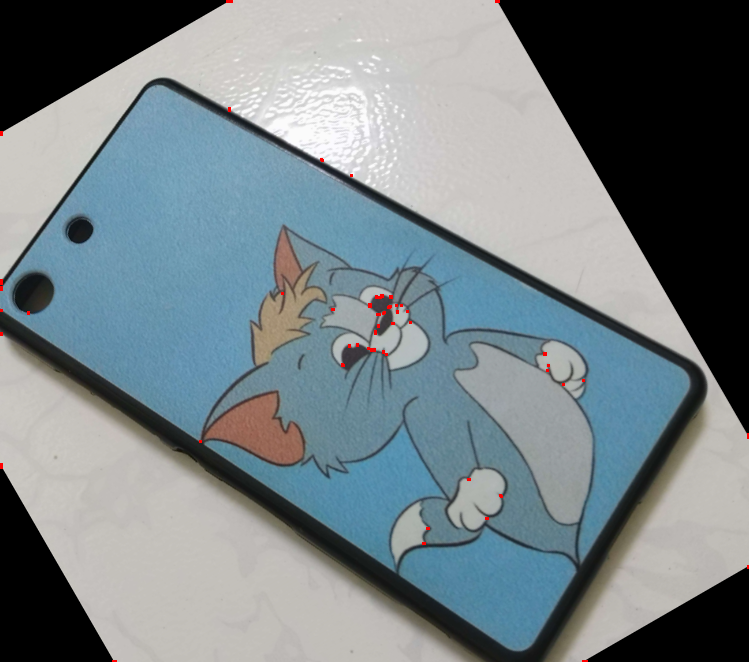

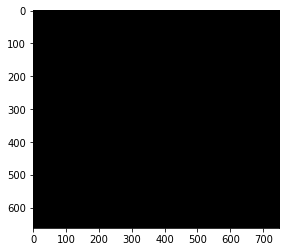

In [ ]:
# def findMatrixRotateSIFT(self, image2, list_kp1, list_kp2, view = True)
# return matrix
harris_keypoint2 = classtest.Harriscorner(img2, view = True)
matrixlastharris = classtest.findMatrixRotate(img2, harris_keypoint1, harris_keypoint2)

In [ ]:
len(harris_keypoint2)


658

## other example

In [ ]:
# list_kp1, list_kp2 = classtest.siftKeypointCoord(siftresult)
# matrixlast = classtest.findMatrixRotateSIFT(img1, img2)

[[  0.64278761   0.76604444 -39.92506648]
 [ -0.76604444   0.64278761 326.38041863]]


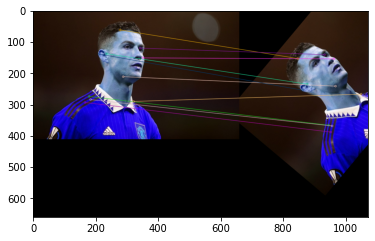

In [ ]:
req = urllib.request.urlopen('https://media.bongda.com.vn/resize/800x800/files/hai.phan/2022/11/18/cr-0600.jpg')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img1 = cv2.imdecode(arr, -1)

classtest = RotateMatrix2D(img1, degree = 50)

img2 = classtest.rotateImage(viewMatrixRotate = True)

siftresult = classtest.sift(img1, img2)

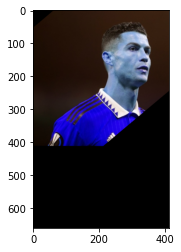

In [ ]:
list_kp1, list_kp2 = classtest.siftKeypointCoord(siftresult)
matrixlast = classtest.findMatrixRotateSIFT(img1, img2)

[[ 6.123234e-17  1.000000e+00  1.705000e+02]
 [-1.000000e+00  6.123234e-17  8.535000e+02]]


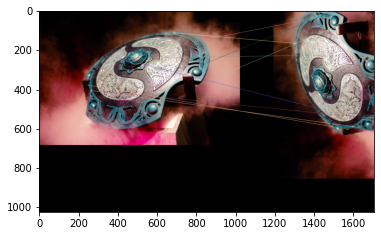

In [ ]:
req = urllib.request.urlopen('https://cdn.oneesports.gg/cdn-data/2021/10/Dota2_Aegis_of_Champions_2017-1024x683.jpg')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img1 = cv2.imdecode(arr, -1)

classtest = RotateMatrix2D(img1, degree = 90)

img2 = classtest.rotateImage(viewMatrixRotate = True)

siftresult = classtest.sift(img1, img2)

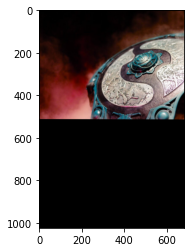

In [ ]:
list_kp1, list_kp2 = classtest.siftKeypointCoord(siftresult)
matrixlast = classtest.findMatrixRotateSIFT(img1, img2)

[[-1.0000000e+00  1.2246468e-16  1.0240000e+03]
 [-1.2246468e-16 -1.0000000e+00  7.0000000e+02]]


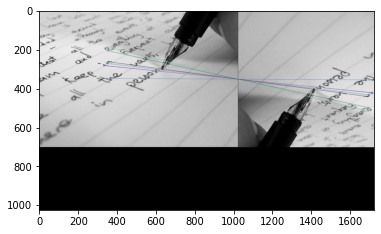

In [ ]:
req = urllib.request.urlopen('https://i0.wp.com/humanepursuits.com/wp-content/uploads/2013/12/letter.jpg?resize=1024%2C700')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img1 = cv2.imdecode(arr, -1)

classtest = RotateMatrix2D(img1, degree = 180)

img2 = classtest.rotateImage(viewMatrixRotate = True)

siftresult = classtest.sift(img1, img2)

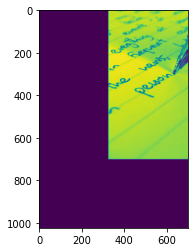

In [ ]:
list_kp1, list_kp2 = classtest.siftKeypointCoord(siftresult)
matrixlast = classtest.findMatrixRotateSIFT(img1, img2)

In [ ]:
req = urllib.request.urlopen('https://blogger.googleusercontent.com/img/a/AVvXsEiEa59UzuBSn-hxboWjuJvUNDrimm0ZmlW-FxGDhUS9mVhPSqSkPwXUqSji0yYK7ZEO4nFhYdJH7ACSc4rL6JRpIBwrTkfLo9BKAsmH7__gUivEKhukGuQ4eKeJ2-1ltqyceOk5MDvvLFlA9RDz_UnTX-wXDaoCTjhXBNbiEGYyIZlURFoRdtMkx3R14Q')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img1 = cv2.imdecode(arr, -1)

sift = cv2.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
img=cv2.drawKeypoints(img1 ,
                      keypoints_1 ,
                      img1 ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('image-with-keypoints.jpg', img)

True